## Import Library

In [1]:
import numpy as np
import pandas as pd


import nltk
from nltk.corpus import stopwords


# tf and Keras
import tensorflow as tf
import keras.api._v2.keras as keras
from keras.api._v2.keras.preprocessing.text import Tokenizer
from keras.api._v2.keras.utils import pad_sequences
import keras.api._v2.keras.models as models
import keras.api._v2.keras.layers as layers
import keras.api._v2.keras.losses as losses
import keras.api._v2.keras.activations as activations
import keras.api._v2.keras.optimizers as optimizers
import keras.api._v2.keras.metrics as metrics

from sklearn.model_selection import KFold,ShuffleSplit,StratifiedKFold

from bs4 import BeautifulSoup as bs
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# seaborn theme
# sns.set_palette(sns.color_palette("husl",4))

# Import DATA

In [3]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

#Shuffle the data
train_df = train_df.sample(frac = 1).reset_index(drop = True)

In [4]:
train_df.head()

,id,keyword,location,text,target
0,9466,terrorism,NaN,DHS Refuses to Call Chattanooga Û÷Islamic Ter...,1
1,1842,burned,"Oakland, CA",Burned dog finds new home with young burn vict...,1
2,10817,wrecked,At your back,Wrecked emotions.,0
3,523,army,NaN,One Direction Is my pick for http://t.co/q2eBl...,0
4,6372,hostages,NaN,No #news of #hostages in #Libya\n\nhttp://t.co...,1


# Text cleaning

In [5]:
from unidecode import unidecode

def text_cleaner(txts):
    txts = txts.lower()
    clean_html_tag = lambda x: str(bs(x, 'html.parser'))
    clean_http = lambda x: str(re.sub(r'http\S+',"",x))
    clean_special_char = lambda x: str(re.sub(r"[^a-zA-Z0-9 ]+","", x))
    remove_mentions = lambda x: str(re.sub(r"@\w+",'',x))
    
    txts = clean_html_tag(clean_http(clean_special_char(remove_mentions(txts))))
    txts = re.sub(r"\d+",'',txts) # Remove all numeric char
    
    return txts.strip() # Remove white space


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [6]:
train_df.text = train_df.text.apply(text_cleaner)
train_df.text = train_df.text.apply(remove_emoji)

In [7]:
# Add text lenght to new column
train_df['text_lenght'] = train_df['text'].apply(
    lambda x : len(x)
)


In [8]:
# target to labels
train_df['label'] = train_df['target'].apply(
    lambda x : 'Disaster' if x == 1 else 'Not disaster'
)

([<matplotlib.axis.XTick at 0x7ff92f5e3290>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

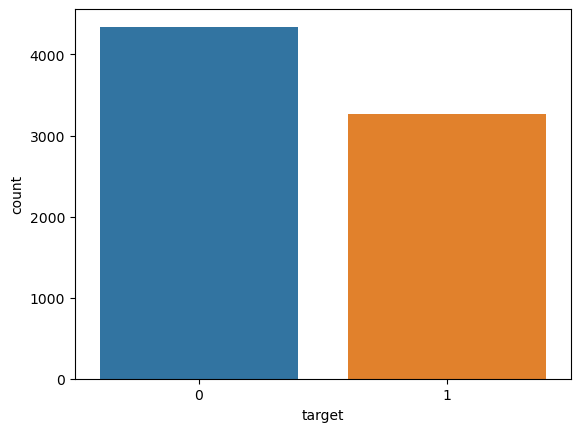

In [9]:
sns.countplot(x = train_df['target'])
plt.xticks(ticks = [0,1])

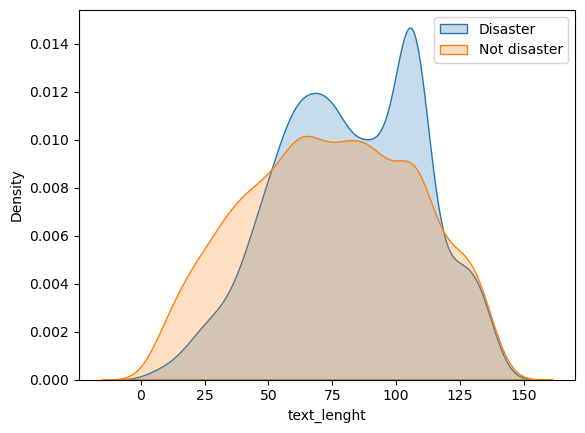

In [10]:
# Distribution of text lenght for each label
def dis_plot(group_col,focus_col):
    labels = train_df[group_col].unique()
    groups = train_df.groupby(group_col)[focus_col]
    for idx, grp in enumerate(groups.apply(list)):
        ax = sns.kdeplot(
            data = grp, label = labels[idx],fill = True
        )
    ax.legend()
    plt.xlabel(focus_col)

dis_plot('label','text_lenght')

# Count Stopwords

In [11]:
stop_words = set(stopwords.words('english'))
def count_stopwords(txts):
    stp_w = [word for word in txts.split() if word in stop_words]
    return len(stp_w)

train_df['stop_words'] = train_df['text'].apply(count_stopwords)

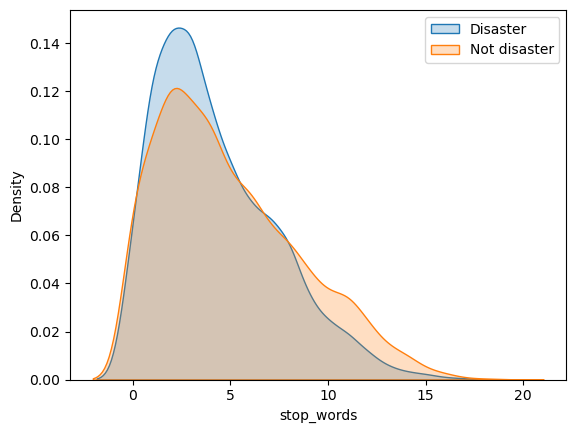

In [12]:
dis_plot('label','stop_words')

# Fold Manager

In [13]:
from dataclasses import dataclass,field

@dataclass
class FoldData:
    train_x: tf.Tensor = field()
    test_x: tf.Tensor = field()
    train_y: tf.Tensor = field()
    test_y: tf.Tensor = field()

class FoldManager:
    
    def extract_fold(self, fold_index:list , X, Y ):
        for train, test in fold_index:
            yield FoldData(
                train_x = tf.gather( X, train ),
                test_x = tf.gather( X, test ),
                train_y = tf.gather( Y, train ),
                test_y = tf.gather( Y, test ) 
            )
    
    # V V V
    
    def train_fold( self, batch_of_folds, ep, batch_size ):
        tf.keras.backend.clear_session()
        md_history = []
        for i,fold in enumerate(batch_of_folds):
            print(f'Fold: {i+1}')
            model.fit(
                fold.train_x,
                fold.train_y,
                epochs = ep,
                batch_size = batch_size,
            )
            
            print('Evaluating....')
            
            model.evaluate(
                fold.test_x,
                fold.test_y,
                batch_size = batch_size
            )

In [14]:
import tensorflow_hub as hub
import tensorflow_text as text 

# Model selector

In [15]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

In [16]:
def build_classifier_model(_name):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(map_model_to_preprocess[_name],trainable = True,name = 'preprocess')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(map_name_to_handle[_name], trainable = True, name = 'encoder')
    outputs = encoder(encoder_inputs)
    lstm = layers.Bidirectional(
                layers.LSTM(16,dropout = 0.2)
            )(outputs['sequence_output'])
    outp = layers.Dropout(0.2, name="dropout")(lstm)
    classifier = tf.keras.layers.Dense(1, activation=None, name='classifier')(outp)
    return tf.keras.Model(text_input, classifier)

In [17]:
model = build_classifier_model('bert_en_cased_L-12_H-768_A-12')

In [18]:
model.compile( loss=losses.BinaryCrossentropy(from_logits = True), 
              optimizer = optimizers.experimental.Adam(learning_rate = 0.0001), 
              metrics = [ 'accuracy', metrics.BinaryAccuracy() ] )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocess (KerasLayer)        {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [19]:
X_input = tf.convert_to_tensor(train_df['text'])

# ## One Hot Encoding
# Y_raw = train_df['target']
# classes = Y_raw.nunique()
# one_h = layers.CategoryEncoding(num_tokens = classes, output_mode = 'one_hot')
# Y_label = tf.convert_to_tensor(one_h(Y_raw))

Y_label = tf.convert_to_tensor(train_df['target'])

In [20]:
shf = StratifiedKFold(n_splits = 3,random_state = 1337, shuffle = True)
splitted = shf.split(X_input,train_df['target'])

fold = FoldManager()
extrc_fold = fold.extract_fold(splitted,X_input,Y_label)
fold.train_fold(extrc_fold,1, batch_size = 32)

Fold: 1
159/159 [==============================] - 135s 556ms/step - loss: 0.4889 - accuracy: 0.7769 - binary_accuracy: 0.7769
Evaluating....
80/80 [==============================] - 20s 226ms/step - loss: 0.4002 - accuracy: 0.8164 - binary_accuracy: 0.8164
Fold: 2
159/159 [==============================] - 89s 557ms/step - loss: 0.3905 - accuracy: 0.8357 - binary_accuracy: 0.8357
Evaluating....
80/80 [==============================] - 18s 224ms/step - loss: 0.3550 - accuracy: 0.8203 - binary_accuracy: 0.8203
Fold: 3
159/159 [==============================] - 89s 557ms/step - loss: 0.3379 - accuracy: 0.8631 - binary_accuracy: 0.8631
Evaluating....
80/80 [==============================] - 18s 225ms/step - loss: 0.2702 - accuracy: 0.8971 - binary_accuracy: 0.8971


In [21]:
pred_one_h = model.predict(test_df['text'])

102/102 [==============================] - 24s 221ms/step


In [22]:
pred_one_h[pred_one_h < 0] = 0
pred_one_h[pred_one_h > 0] = 1

In [23]:
test_df['target'] = pred_one_h.astype('int')

In [24]:
sub_df = test_df[['id','target']].reset_index(drop = True)
sub_df[:500]

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
495,1616,1
496,1620,0
497,1624,0
498,1629,1


In [25]:
sub_df.to_csv('submission.csv', index=False)